In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from statsmodels.tsa.arima.model import ARIMA

In [2]:
df = pd.read_csv('../airline_passengers.csv', index_col='Month', parse_dates=True)

In [3]:
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


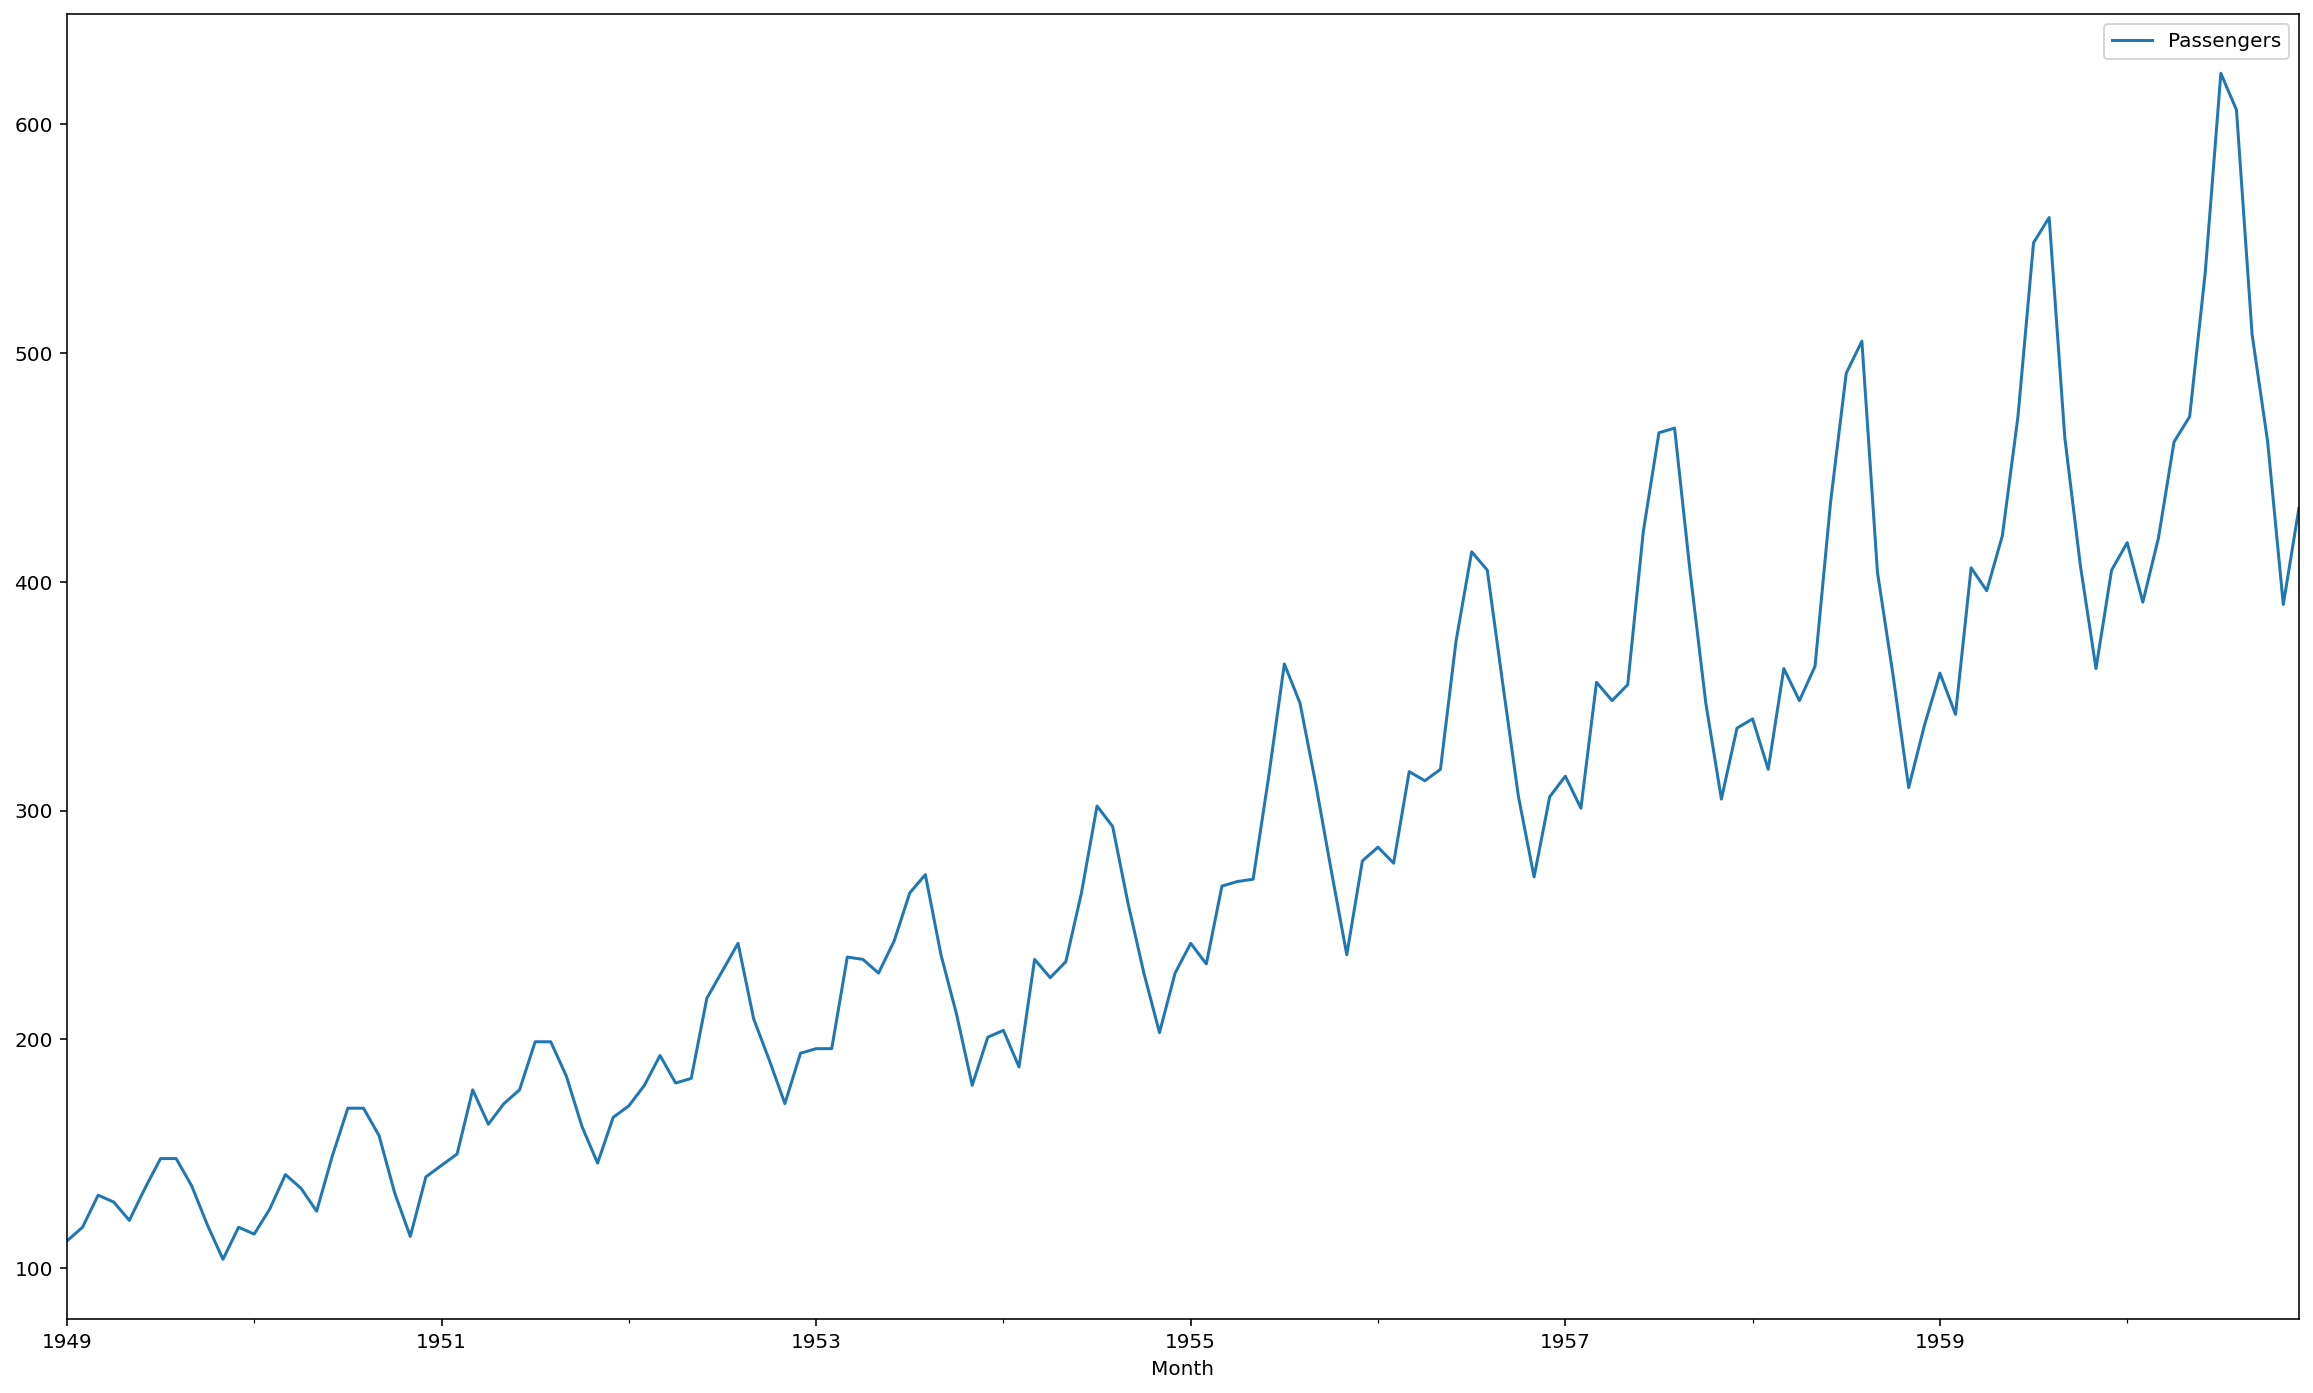

In [4]:
df.plot(figsize=(20, 12));

### First Difference

In [5]:
df['First_Diff'] = df['Passengers'].diff()

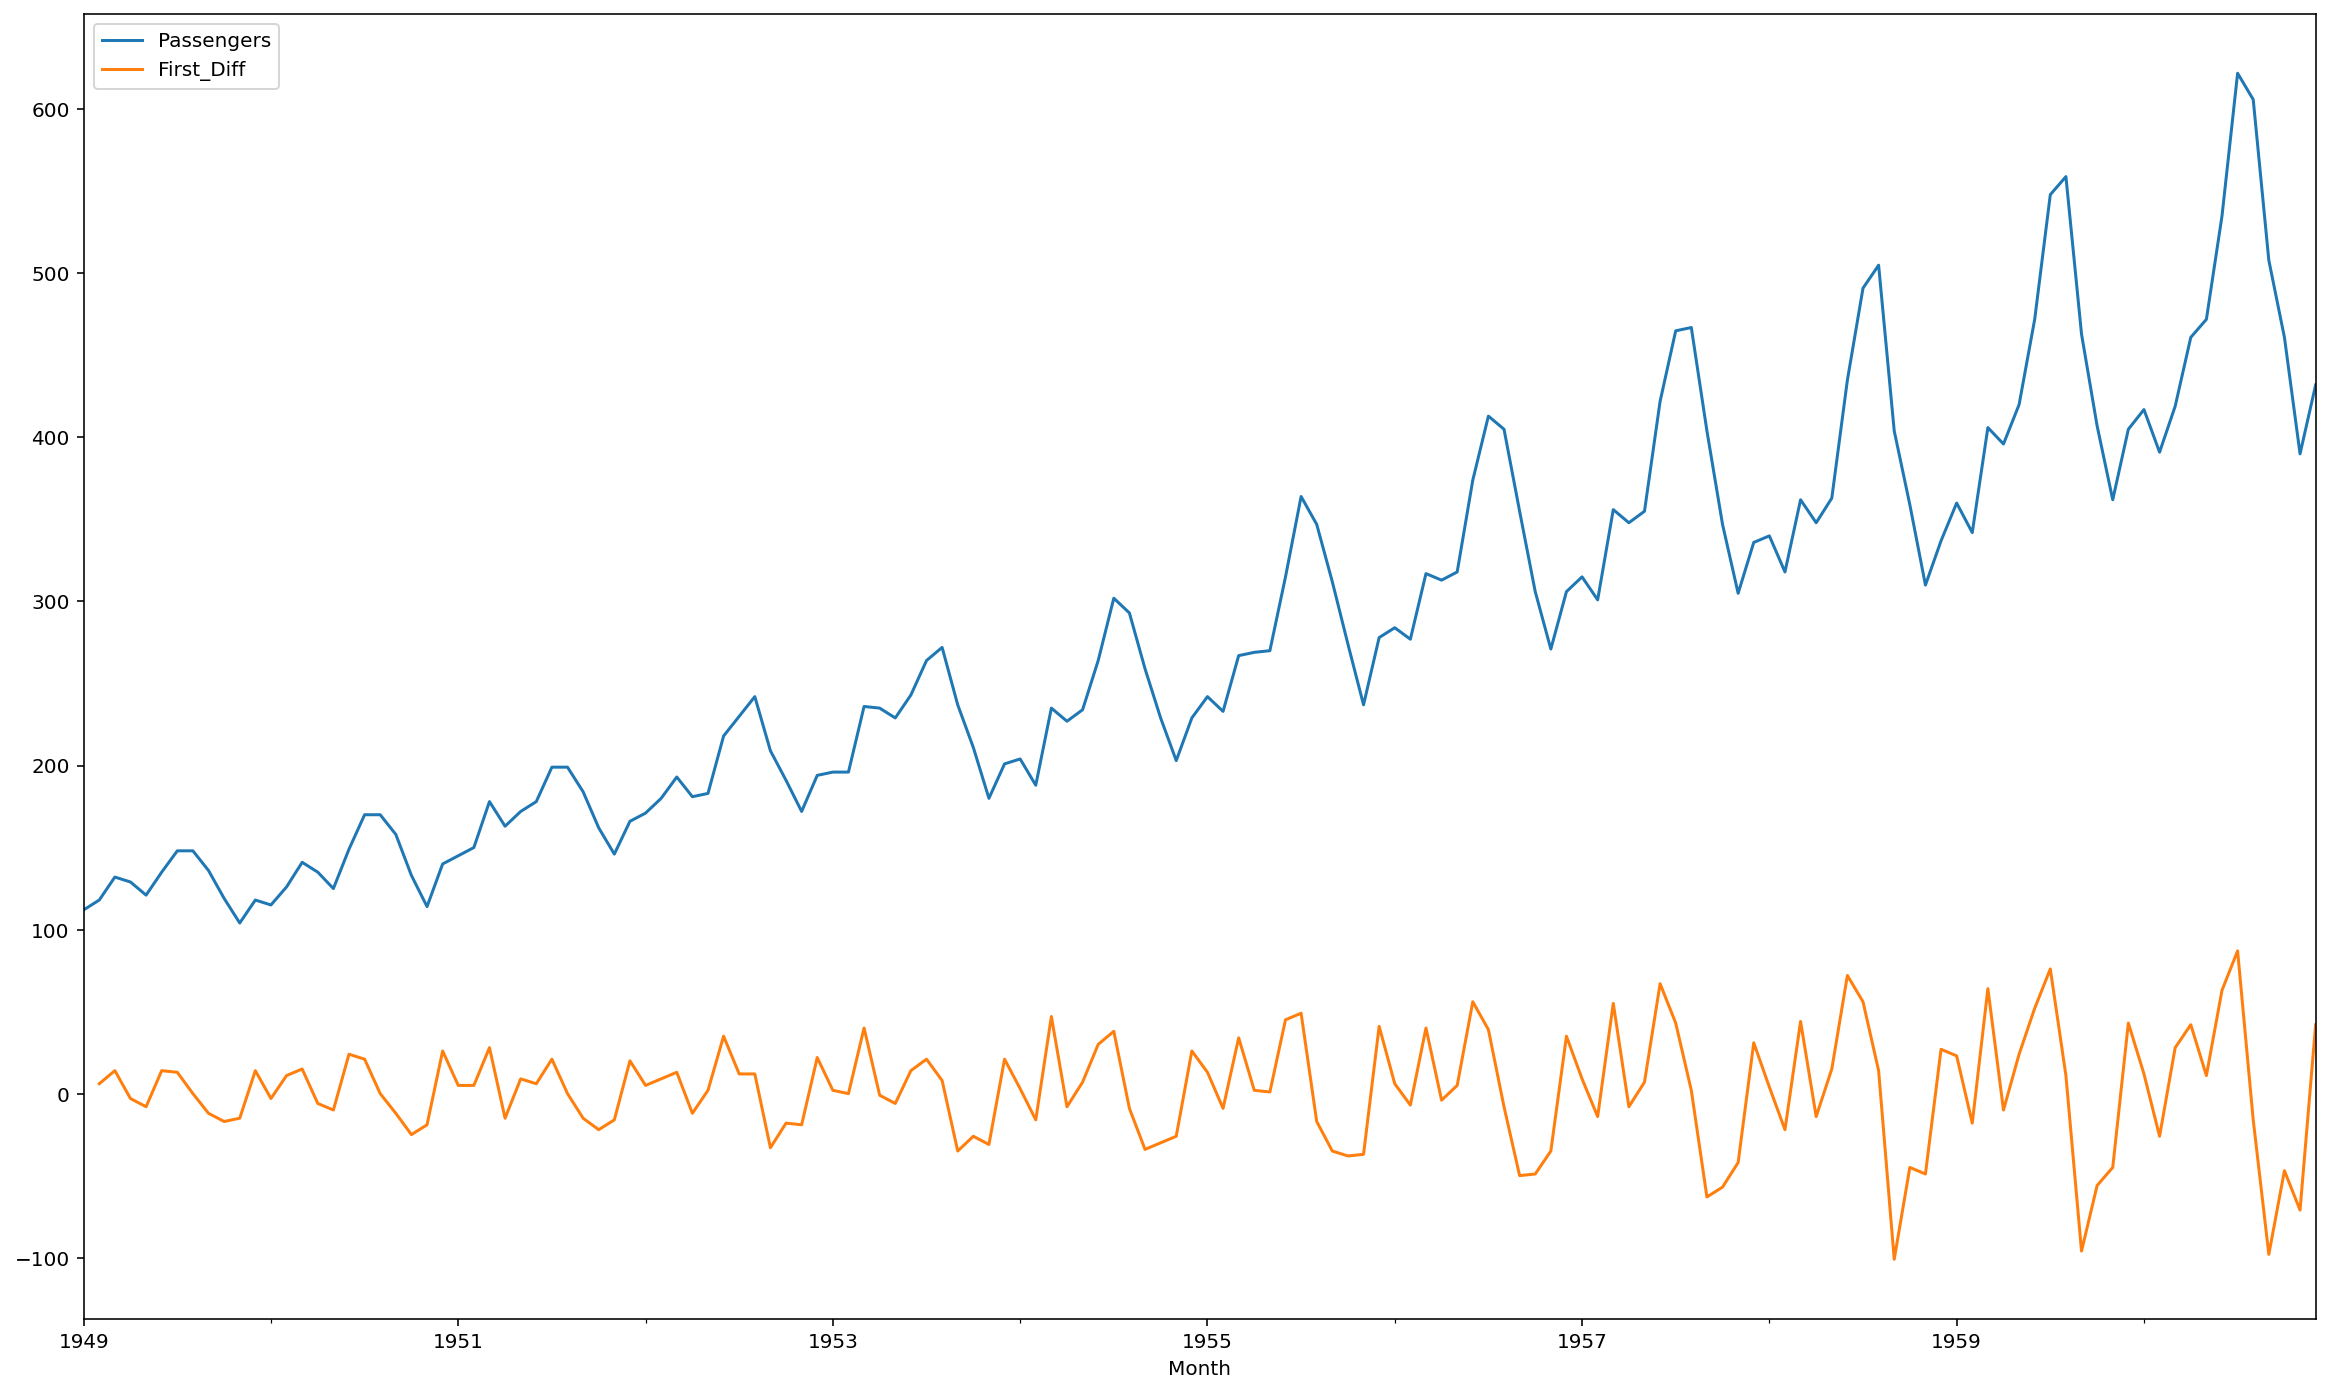

In [6]:
df.plot(figsize=(20, 12));

### Log Price

In [7]:
df['Log_Passangers'] = np.log(df['Passengers'])

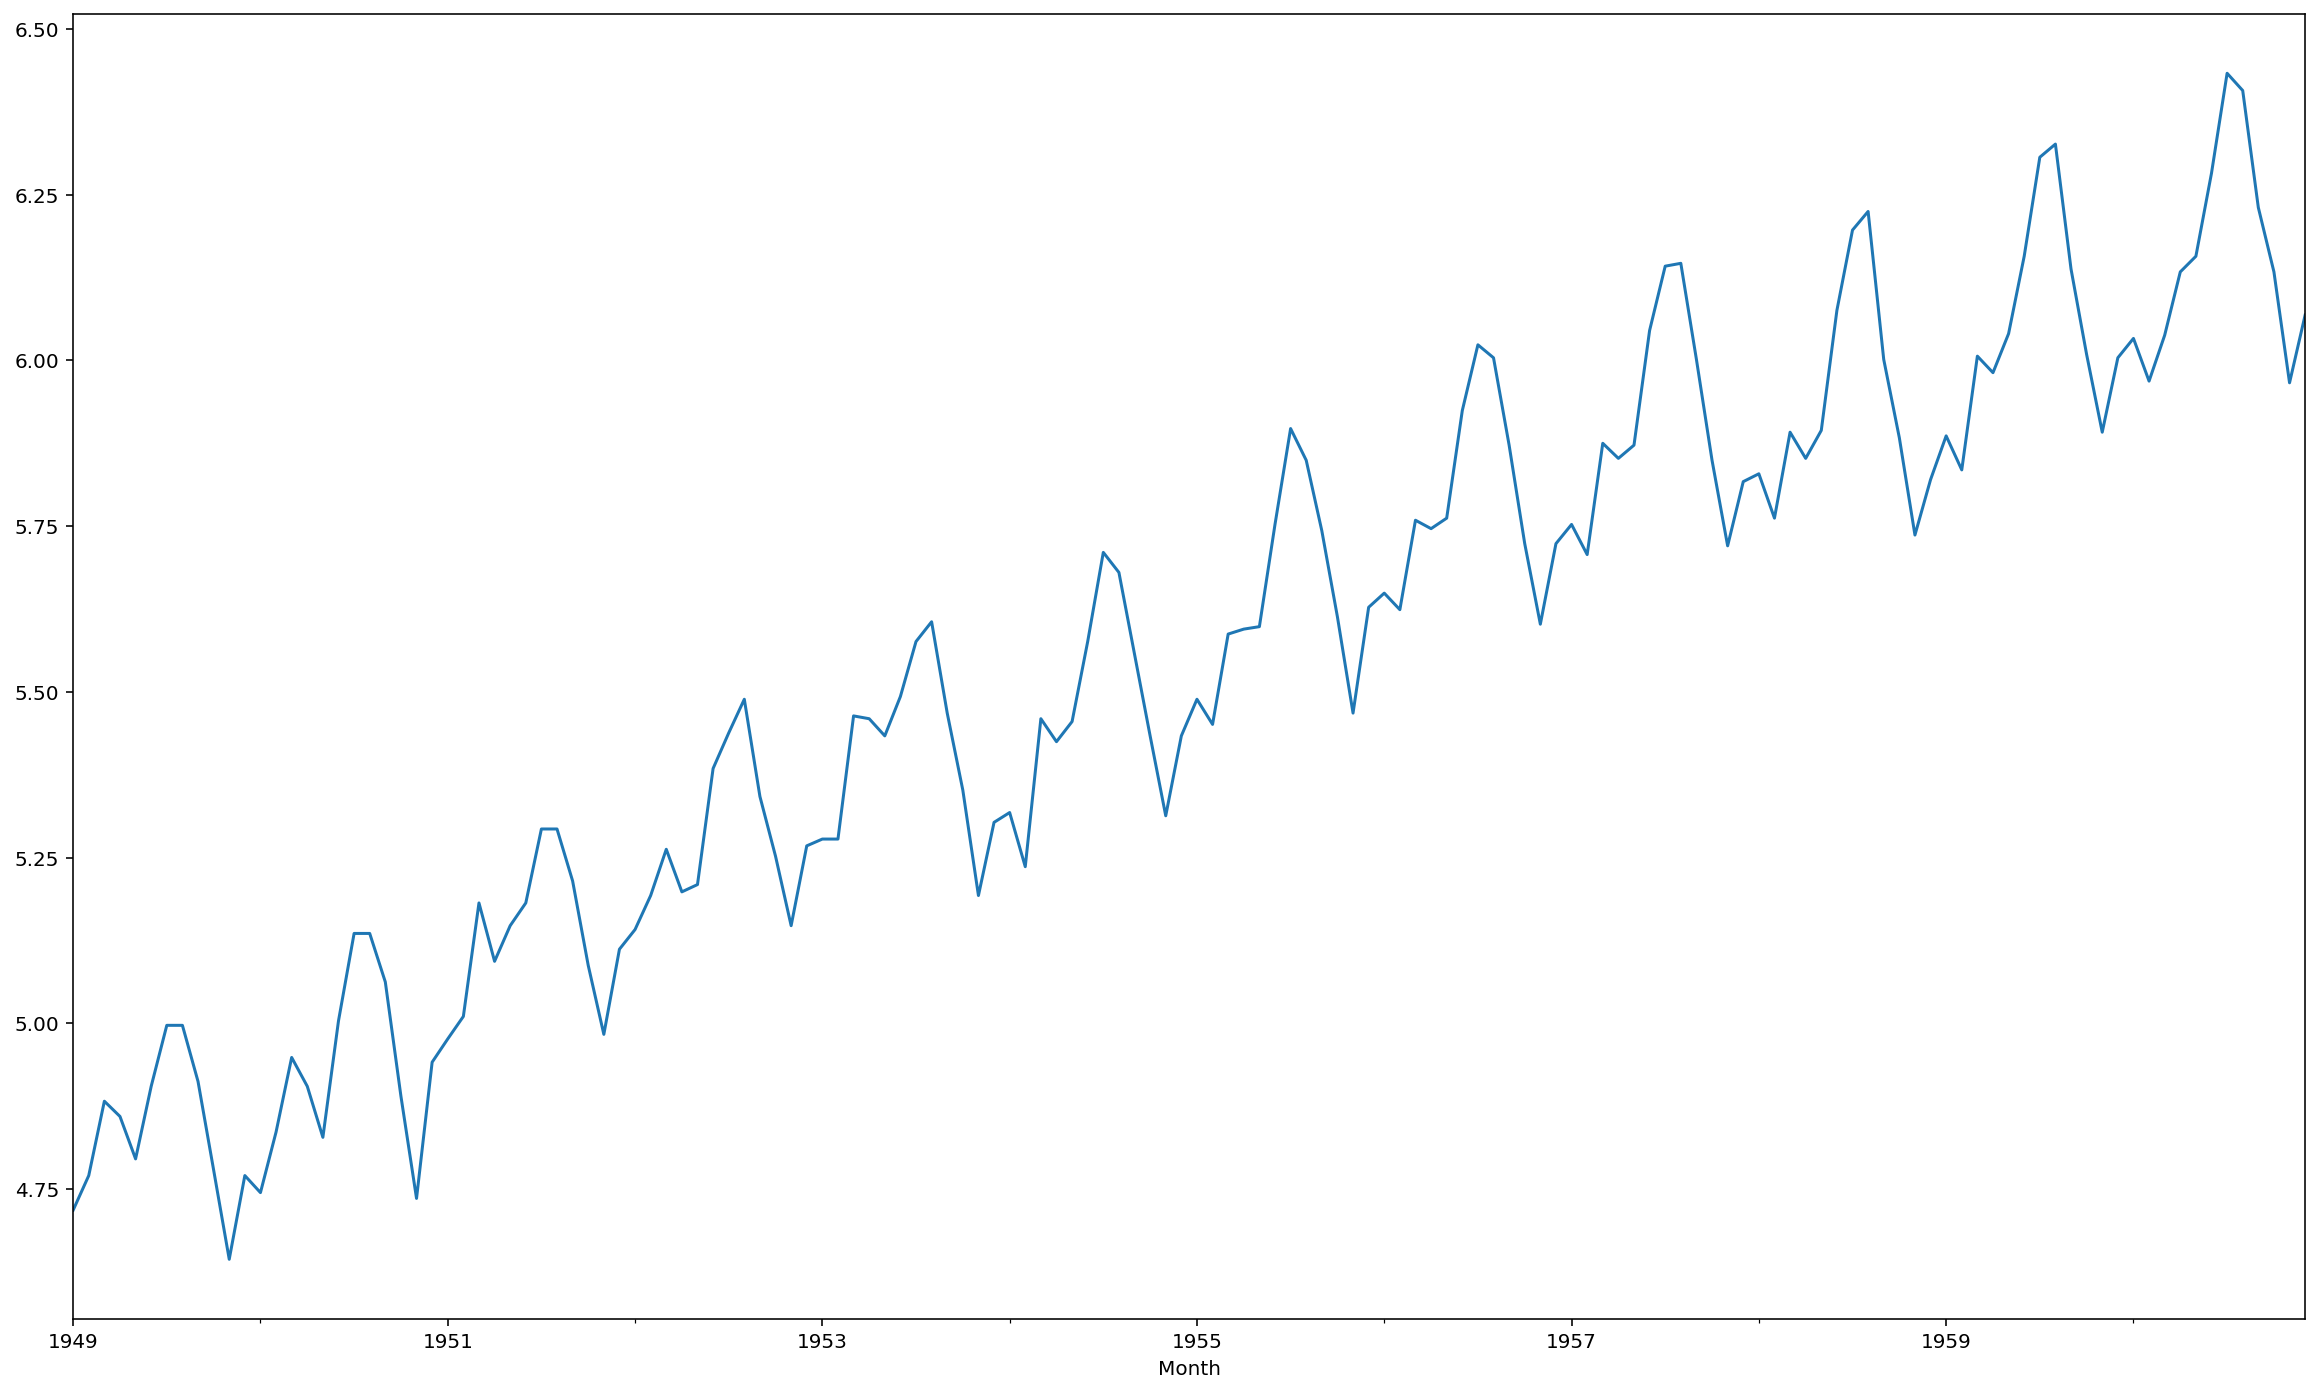

In [8]:
df['Log_Passangers'].plot(figsize=(20, 12));

На лог-цене тренд становится линейным

### ARIMA

In [9]:
df.index.freq = 'MS'

In [10]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [11]:
# Маски по индексам
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [12]:
arima = ARIMA(train['Passengers'], order=(1,0,0))

In [13]:
arima_result = arima.fit()

In [14]:
df.loc[train_idx, 'AR(1)'] = arima_result.predict(start=train.index[0], end=train.index[-1])
# либо вот так на ттренинговой выборке можно получать результаты
# df.loc[train_idx, 'AR(1)'] = arima_result.fittedvalues

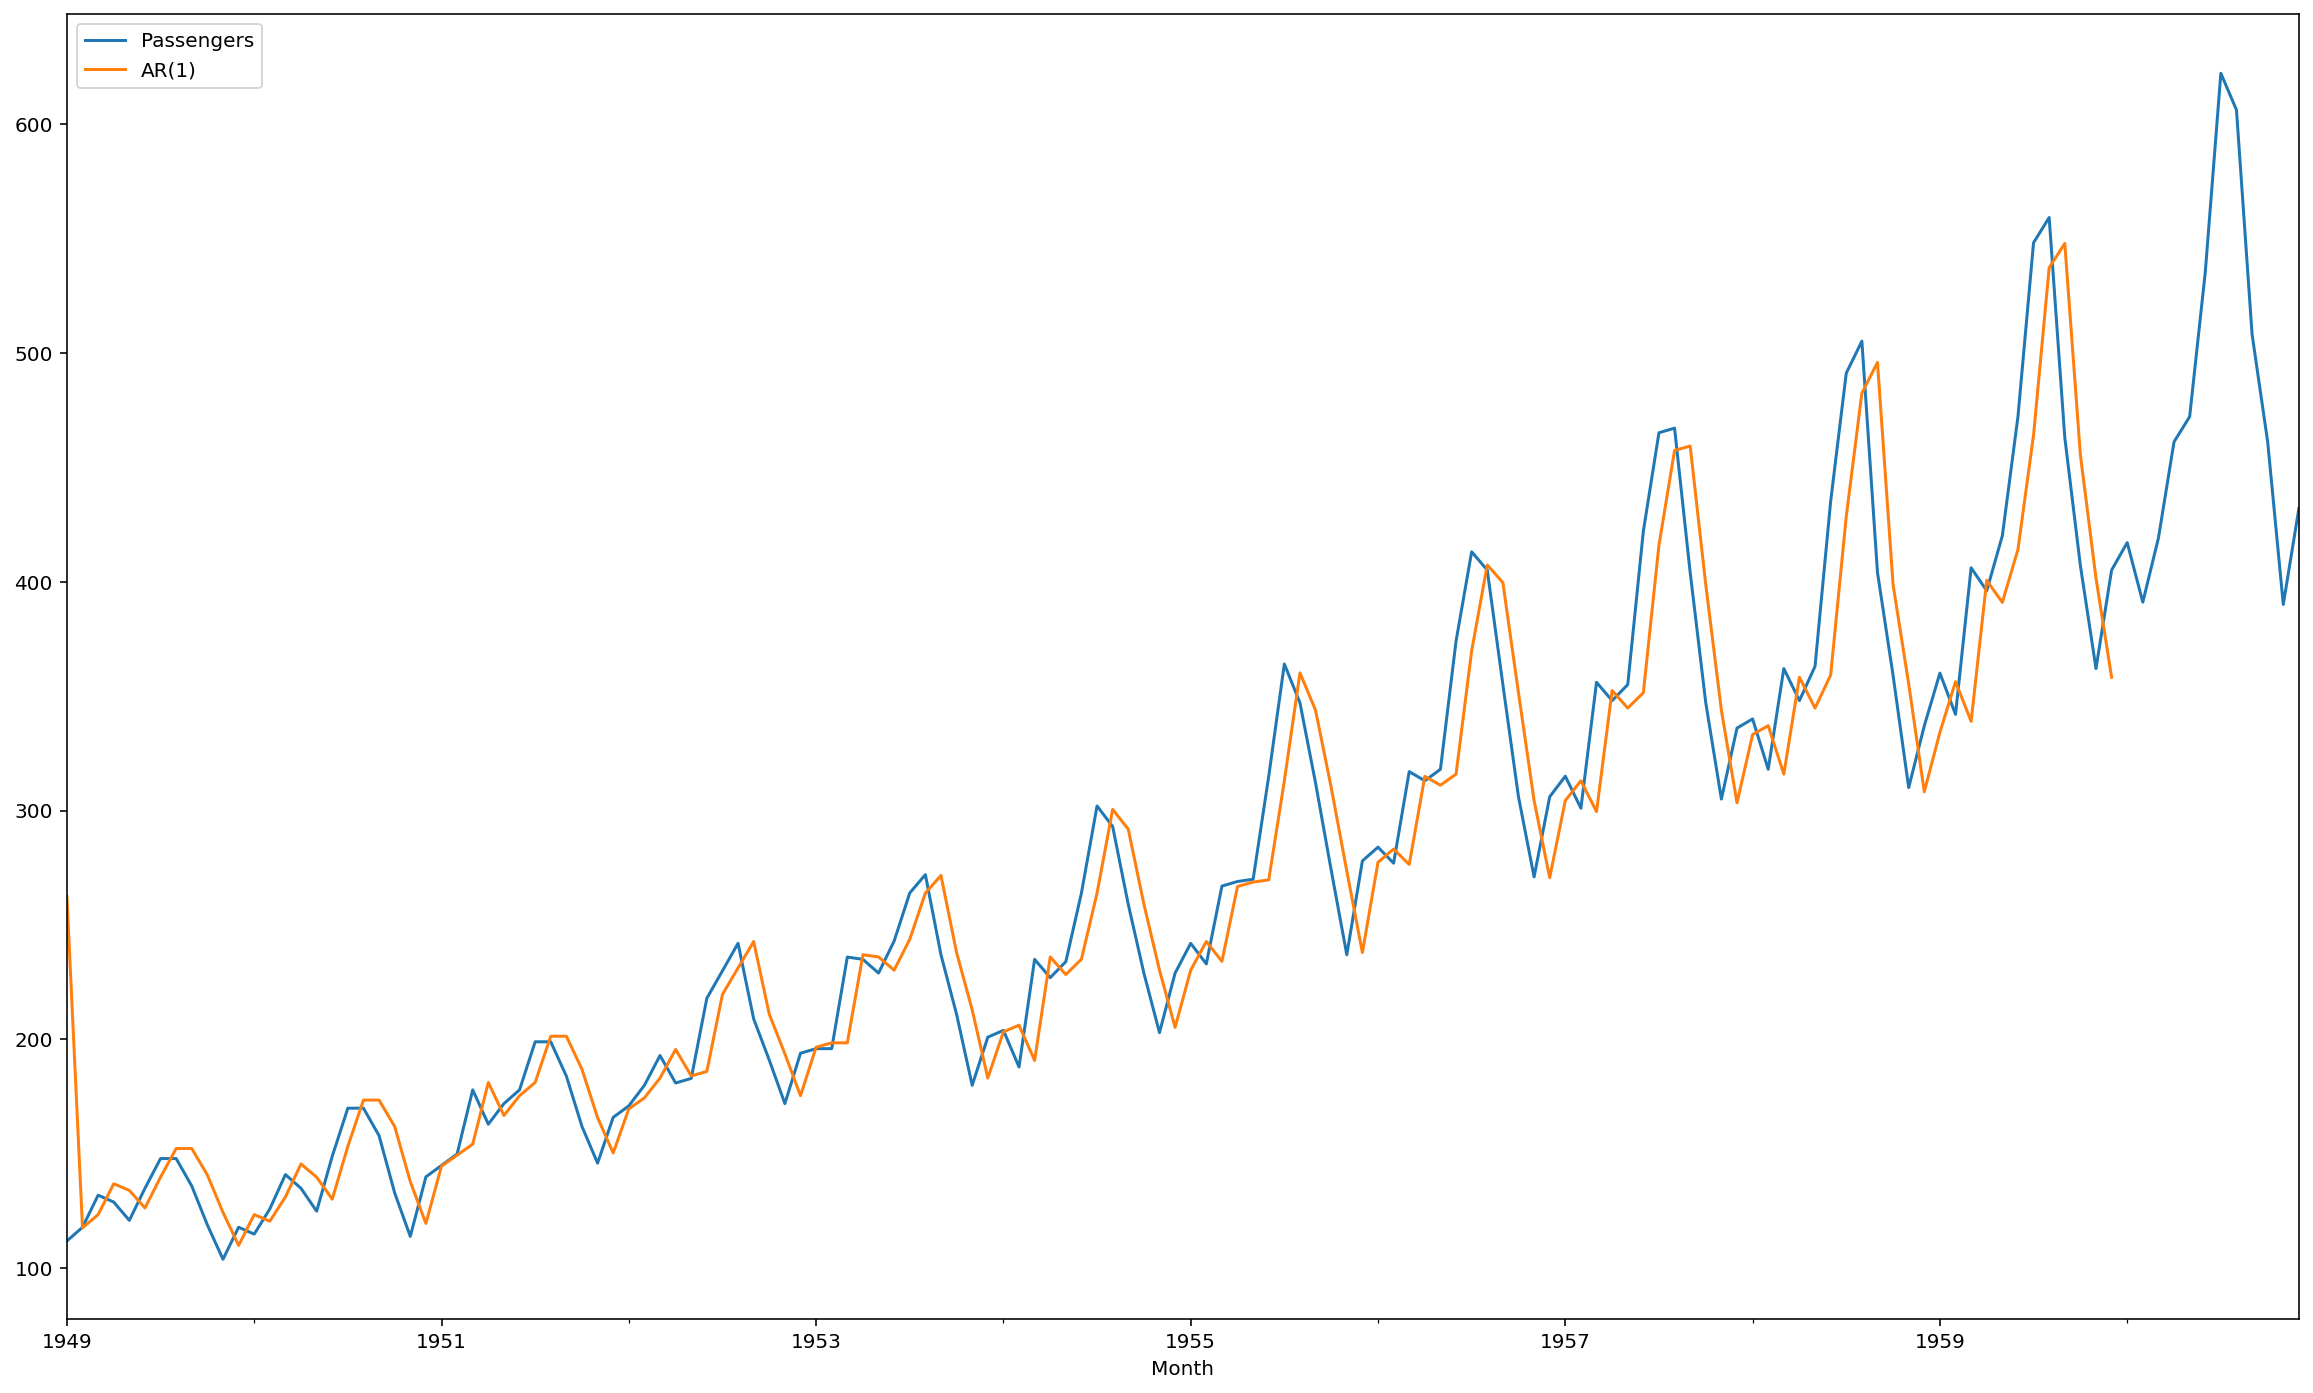

In [15]:
df[['Passengers', 'AR(1)']].plot(figsize=(20,12));

Фактически имеем разновидность наивного прогноза, запаздывание в 1 шаг

###  Прогноз с указанного элемента

In [30]:
prediction_result = arima_result.get_forecast(N_test)
forecast = prediction_result.predicted_mean
df.loc[test_idx, 'AR(1)'] = forecast

# либо вот так на будущий период можно получить прогноз
# arima_result.predict(start=test.index[0], end=test.index[-1])

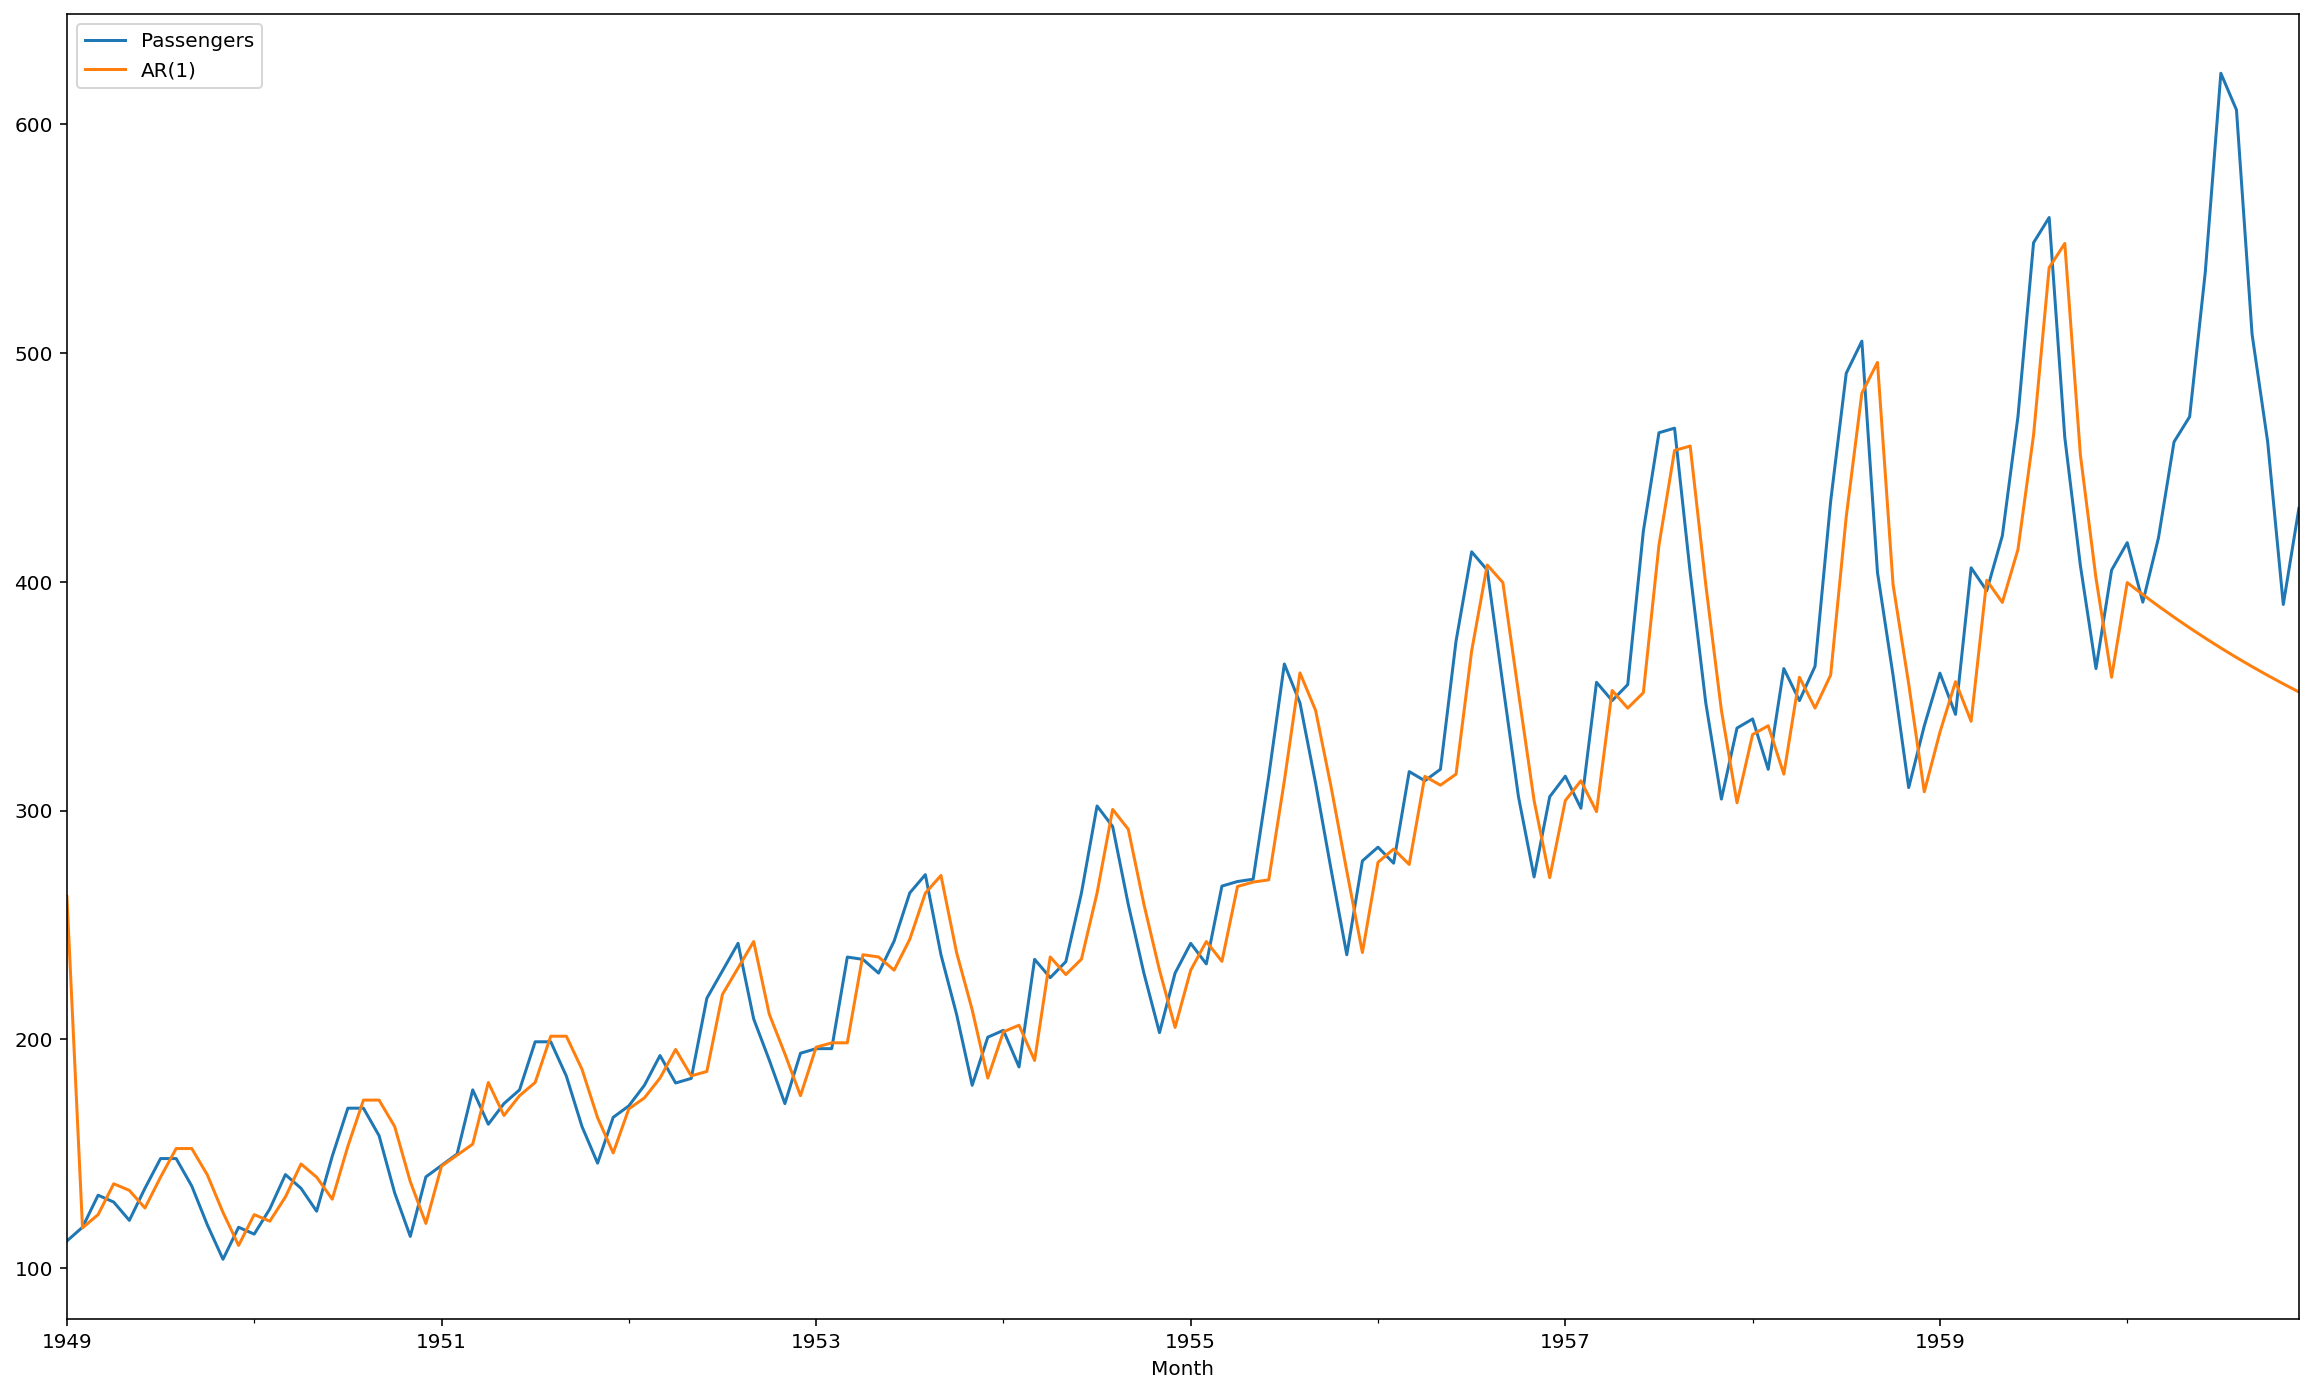

In [25]:
df[['Passengers', 'AR(1)']].plot(figsize=(20,12));

In [31]:
# Explore prediction result
type(prediction_result)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

In [36]:
# Confidence interval
prediction_result.conf_int()

,lower Passengers,upper Passengers
1960-01-01,338.658210,460.451500
1960-02-01,309.826171,478.809354
1960-03-01,287.732168,490.829379
1960-04-01,269.338256,499.534230
1960-05-01,253.432284,506.121347
1960-06-01,239.373402,511.217437
1960-07-01,226.768868,515.201638
1960-08-01,215.354570,518.324977
1960-09-01,204.941150,520.764224
1960-10-01,195.386337,522.649550


In [52]:
def plot_fit_and_forecast(arima_result):
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.plot(df['Passengers'], label='Data')
    
    # plot curve on train set
    train_pred = arima_result.fittedvalues
    ax.plot(train.index.to_numpy(), train_pred.to_numpy(), color='green', label='fitted')
    
    # forecast the test set
    prediction_result = arima_result.get_forecast(N_test)
    conf_int = prediction_result.conf_int()
    lowwer, upper = conf_int['lower Passengers'], conf_int['upper Passengers']
    forecast = prediction_result.predicted_mean
    ax.plot(test.index.to_numpy(), forecast.to_numpy(), label='forecast')
    ax.fill_between(test.index, lowwer, upper, color='Red', alpha=0.2)
    ax.legend()
    

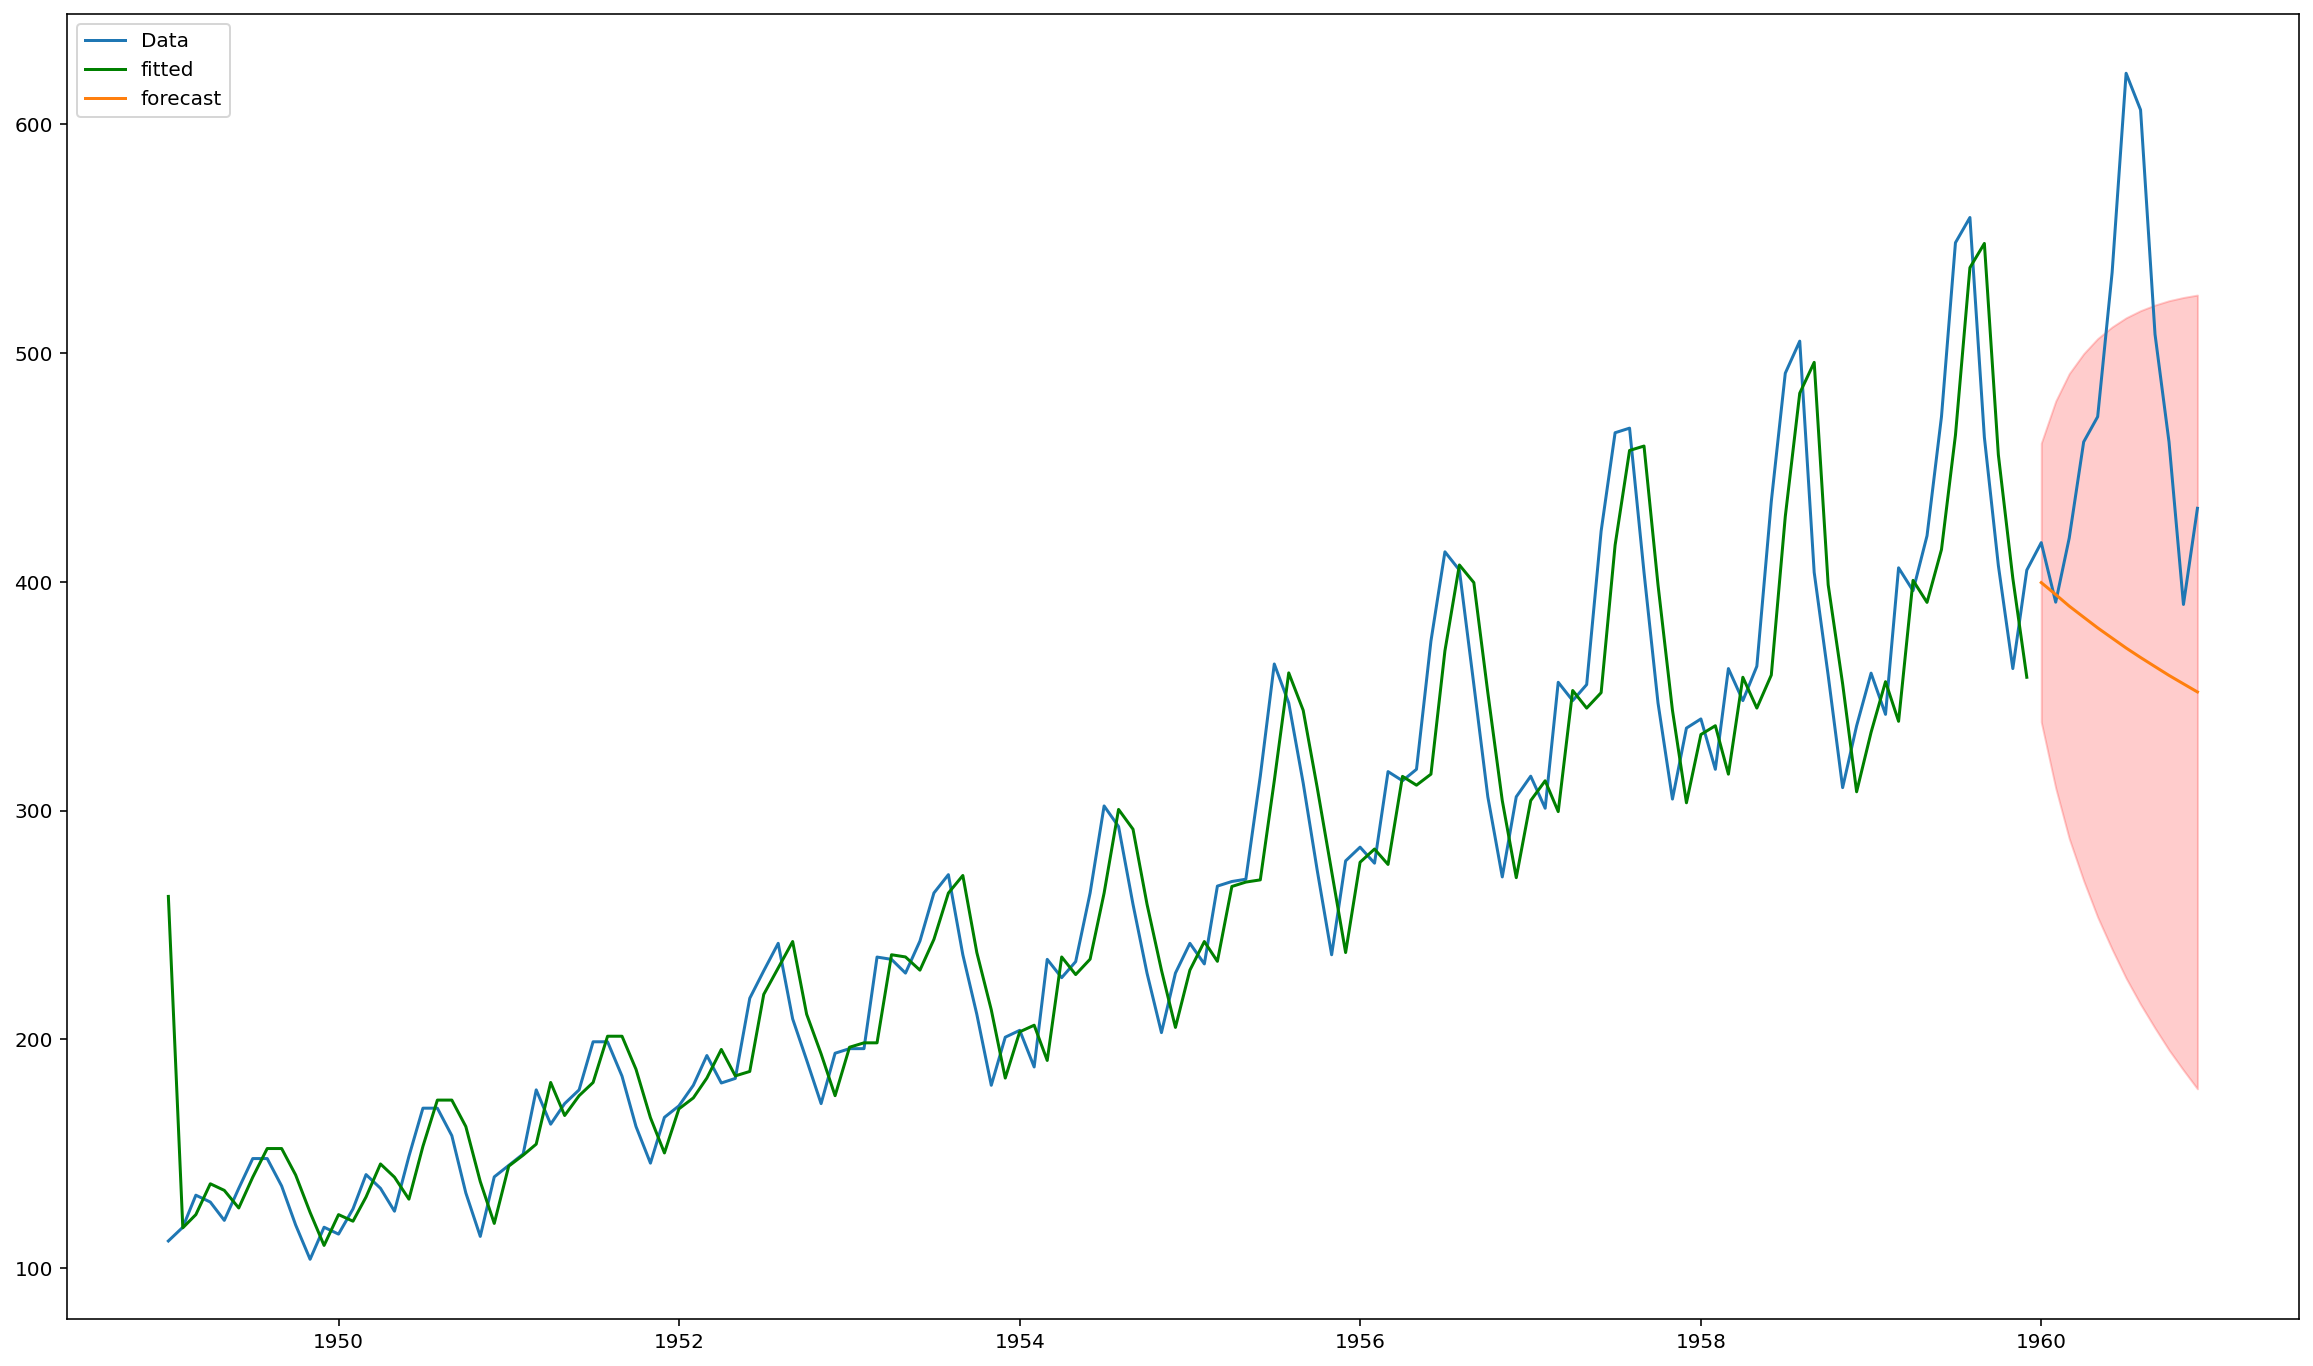

In [53]:
plot_fit_and_forecast(arima_result)

# Добавим больше inputs in AR

c:\Program Files\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Program Files\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


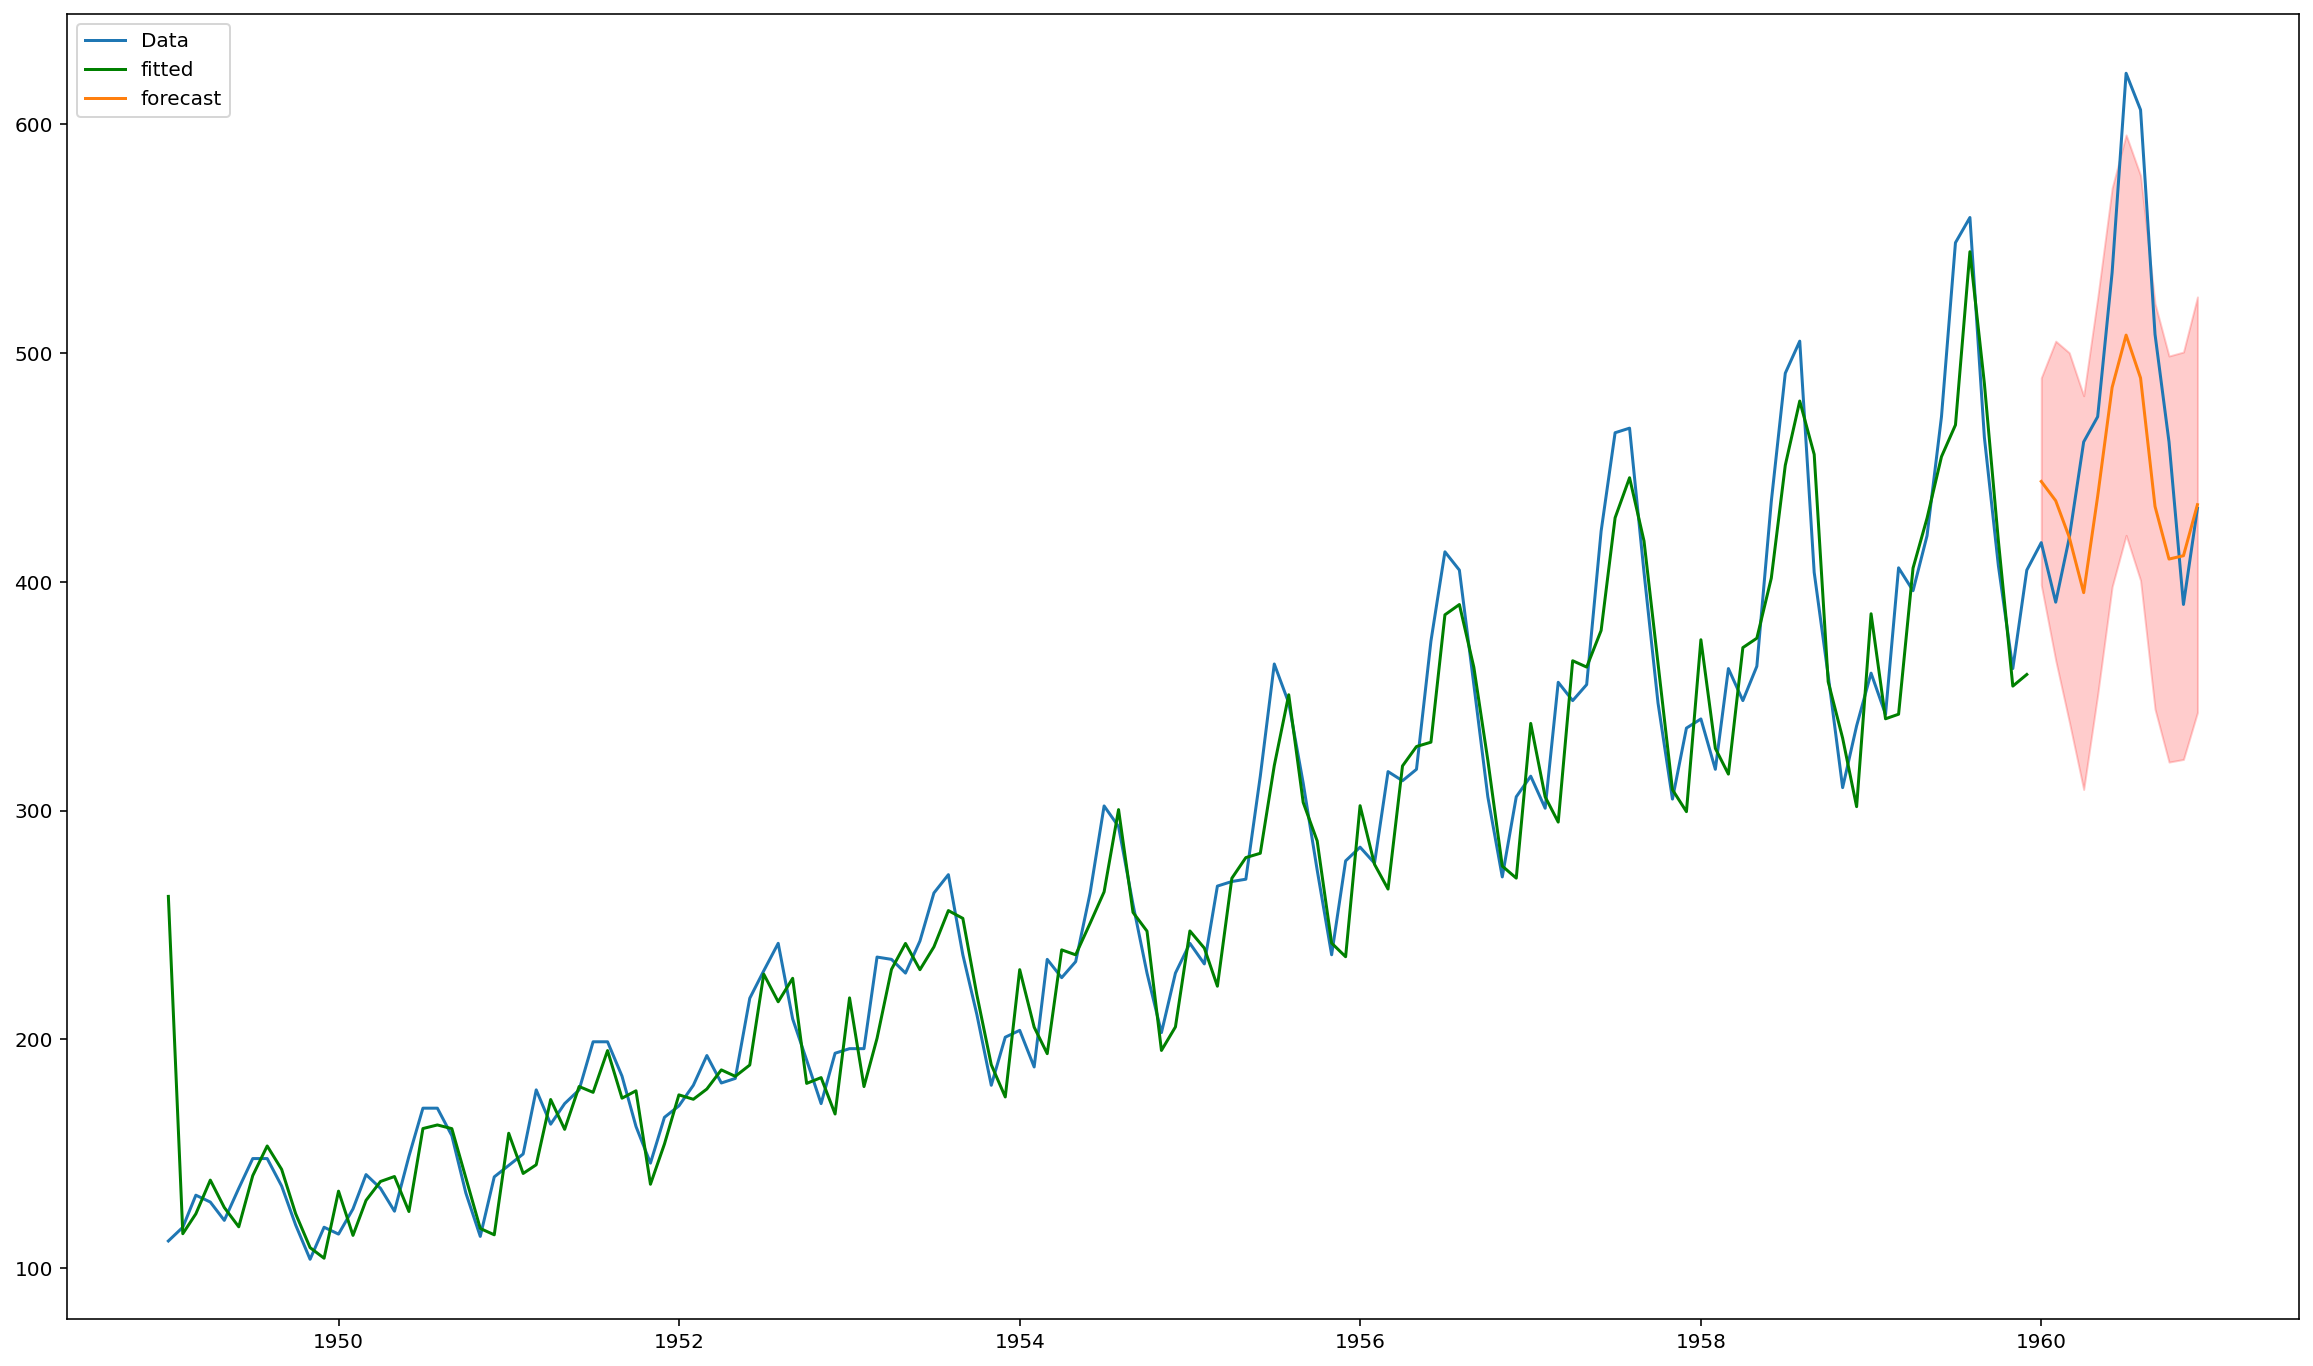

In [55]:
# AR(10)
arima = ARIMA(train['Passengers'], order=(10, 0, 0))
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)


С 10 признаками в последовательности исторических данных модель выглядит более качественно

c:\Program Files\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


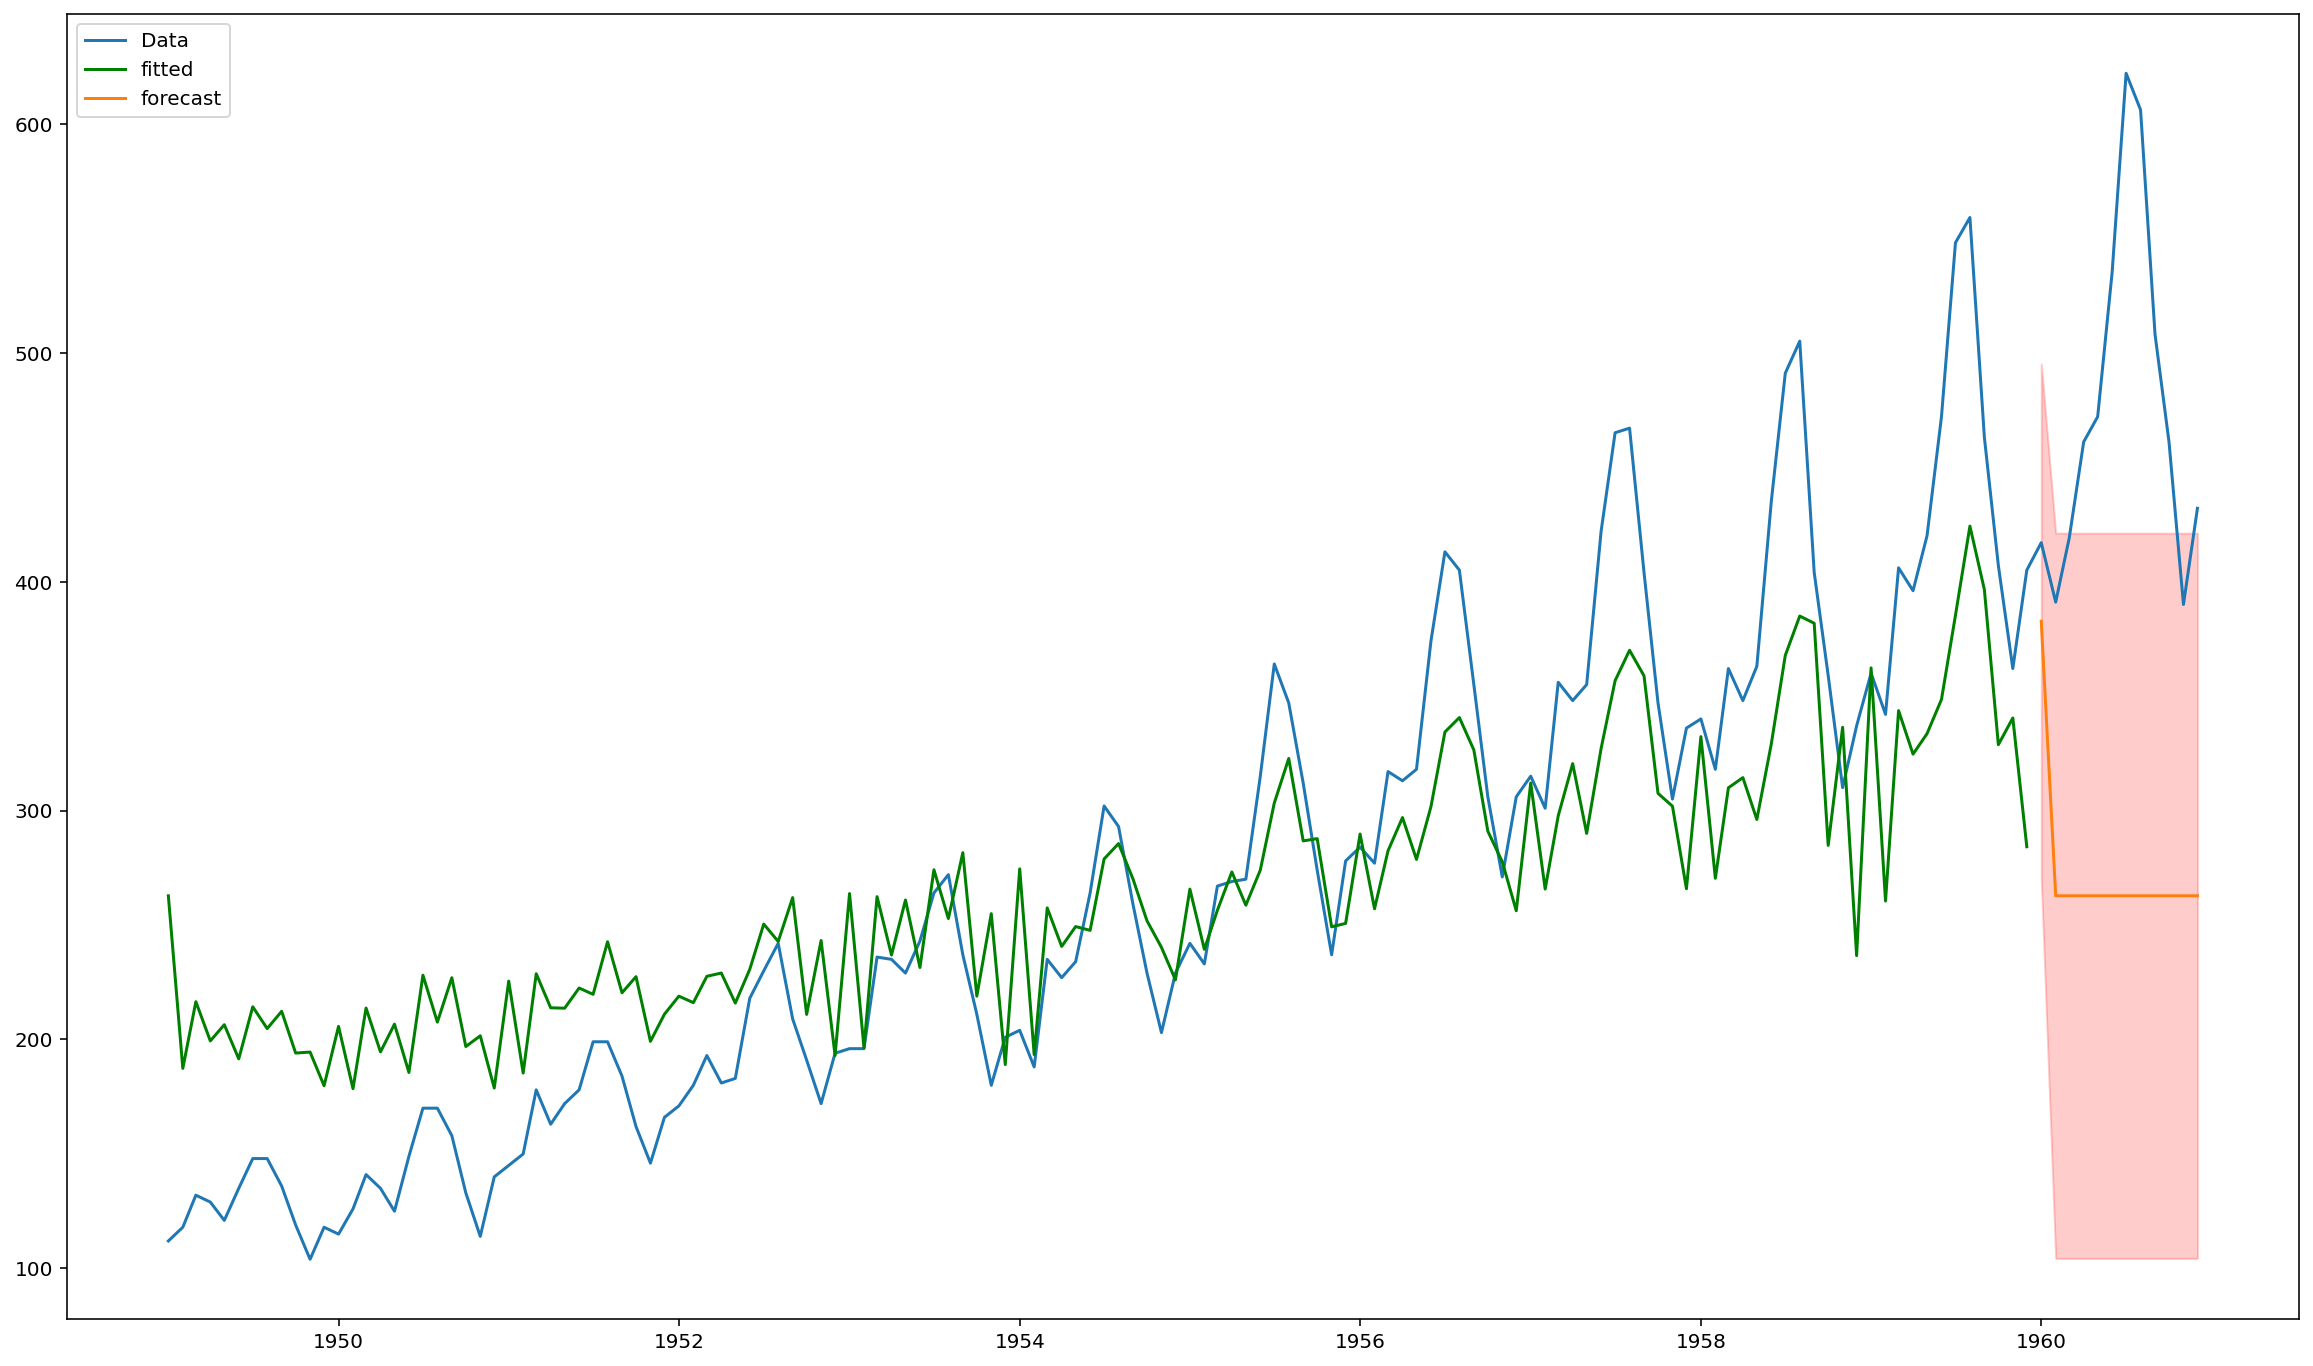

In [58]:
# MA(1)
arima = ARIMA(train['Passengers'], order=(0, 0, 1))
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

### Пробуем перейти к логарифмированному признаку

In [ ]:
df['Log_Passangers']